In [60]:
from ase.build import mx2
from gpaw import GPAW, PW, FermiDirac

structure = mx2(formula='MoS2', kind='2H', a=3.184, thickness=3.127,size=(1, 1, 1), vacuum=3.5)
structure.pbc = (1, 1, 0)

calc = GPAW(mode=PW(400),xc='PBE',setups={'Mo': '6'}, parallel={'kpt': 1},kpts={'size': (4,4,1), 'gamma': True},occupations=FermiDirac(0.01))

structure.set_calculator(calc)
structure.get_potential_energy()
calc.write('MoS2_gs.gpw', 'all')



  ___ ___ ___ _ _ _  
 |   |   |_  | | | | 
 | | | | | . | | | | 
 |__ |  _|___|_____|  1.3.0
 |___|_|             

User:   Yaroslav@MacBook-Pro-Aroslav-2.local
Date:   Sat Mar 24 21:09:54 2018
Arch:   x86_64
Pid:    26858
Python: 2.7.14
gpaw:   /Users/Yaroslav/Library/Python/2.7/lib/python/site-packages/gpaw
_gpaw:  /Users/Yaroslav/Library/Python/2.7/lib/python/site-packages/_gpaw.so
ase:    /usr/local/lib/python2.7/site-packages/ase (version 3.15.0)
numpy:  /Users/Yaroslav/Library/Python/2.7/lib/python/site-packages/numpy (version 1.13.3)
scipy:  /usr/local/lib/python2.7/site-packages/scipy (version 0.19.1)
units:  Angstrom and eV
cores:  1

Input parameters:
  kpts: {gamma: True,
         size: (4, 4, 1)}
  mode: {ecut: 400.0,
         name: pw}
  occupations: {name: fermi-dirac,
                width: 0.01}
  setups: {Mo: 6}
  xc: PBE

Timing:                              incl.     excl.
-----------------------------------------------------------
Full diag:                       

In [61]:
calc.diagonalize_full_hamiltonian()
calc.write('gs_MoS2.gpw', mode='all')

Diagonalizing full Hamiltonian (1605 lowest bands)
Matrix size (min, max): 1605, 1625
Approximate memory used per core to store H_GG, S_GG: 120.878 MB
Notice: Up to twice the amount of memory might be allocated
during diagonalization algorithm.
The least memory is required when the parallelization is purely
over states (bands) and not k-points, set GPAW(..., parallel={'kpt': 1}, ...).
72.9031600952s |----------------------------------------| Time: 75.486s
Writing to gs_MoS2.gpw (mode='all')



In [62]:
from gpaw.response.g0w0 import G0W0
gw = G0W0(calc='gs_MoS2.gpw',
              bands=(8, 11),
              ecut=80,
              truncation='2D',
              nblocksmax=True,
              anisotropy_correction=True,
              filename='MoS2_g0w0',
              savepckl=True)
result=gw.calculate()

In [63]:
from gpaw.response import bse 

ecut = 50
eshift = 0.8

bse = bse.BSE('gs_MoS2.gpw',
          ecut=ecut,
          valence_bands=[8],
          conduction_bands=[9,10],
          truncation='2D',
          nbands=50,
          eshift=eshift,
          mode='BSE',
          integrate_gamma=1,
          txt='bse_MoS2_trun.txt')

In [64]:
import numpy as np

from gpaw.kpt_descriptor import KPointDescriptor
from gpaw.wavefunctions.pw import PWDescriptor

from gpaw.response.kernels import get_coulomb_kernel
from gpaw.response.pair import PairDensity

from itertools import product

import matplotlib.pyplot as plt
%matplotlib inline

In [65]:
nK = bse.kd.nbzkpts
valence_bands=[8]
conduction_bands=[9,10]
nv=len(valence_bands)
nc=len(conduction_bands)
kpoints=bse.kd.bzk_kc

In [73]:
Ef=calc.get_fermi_level()
enk=result['qp'][0]-Ef

In [74]:
env=enk[:,:nv];enc=enk[:,nv:]

In [78]:
enk

array([[-1.12931579,  2.71279163,  2.71409256],
       [-1.81909887,  1.99916997,  2.24823141],
       [-1.53758259,  2.02126218,  2.73536071],
       [-1.85501618,  2.18051012,  2.68437268]])

In [8]:
# Calculate exchange interaction
bse.q_c=[0.0, 0.0, 0.0]
bse.wstc=None
qd0 = KPointDescriptor([bse.q_c])
pd0 = PWDescriptor(bse.ecut, bse.calc.wfs.gd, complex, qd0)
ikq_k = bse.kd.find_k_plus_q(bse.q_c)
v_G = get_coulomb_kernel(pd0, bse.kd.N_c, truncation=bse.truncation, wstc=None)
bse.pair = PairDensity(bse.calc, bse.ecut)
bse.Q_qaGii = []
bse.W_qGG = []
bse.pd_q = []
bse.get_screened_potential(ac=1.0)

In [85]:
bse.Q_qaGii = []
bse.W_qGG = []
bse.pd_q = []
bse.q_c=[0.,0.,0.]
bse.wstc=None
qd0 = KPointDescriptor([bse.q_c])
pd0 = PWDescriptor(bse.ecut, bse.calc.wfs.gd, complex, qd0)
v_G = get_coulomb_kernel(pd0, bse.kd.N_c, truncation=bse.truncation, wstc=None)
bse.pair = PairDensity(bse.calc, bse.ecut)
bse.get_screened_potential()
paw_corrections = bse.pair.initialize_paw_corrections(pd0)

Shifting Fermi-level by 0.00 eV
Number of completely filled bands: 9
Number of partially filled bands: 9
Total number of bands: 1605
Number of blocks: 1


In [127]:
H_trion=np.zeros((nK,nK,nc,nc,nv,
                  nK,nK,nc,nc,nv),dtype=np.complex)
for k1 in range(nK):
    for k2 in range(nK):
        k3=bse.kd.find_k_plus_q(kpoints[k2])[k1]
        for v in range(nv):
            H_trion[k1,k2,:,:,v,k1,k2,:,:,v]-=env[bse.kd.bz2ibz_k[k3],v]
for k in range(nK):
    for c in range(nc):
        H_trion[k,:,c,:,:,k,:,c,:,:]+=enc[bse.kd.bz2ibz_k[k],c]
        H_trion[:,k,:,c,:,:,k,:,c,:]+=enc[bse.kd.bz2ibz_k[k],c]

for k1,k2 in product(range(nK),range(nK)):
    for c1 in range(nc):
        for c2 in range(nc):
            kpt1_1 = bse.pair.get_k_point(0, k1, conduction_bands[c1], conduction_bands[c1]+1)
            kpt2_1 = bse.pair.get_k_point(0, k1, conduction_bands[c2], conduction_bands[c2]+1)
        
            kpt1_2 = bse.pair.get_k_point(0, k2, conduction_bands[c1], conduction_bands[c1]+1)
            kpt2_2 = bse.pair.get_k_point(0, k2, conduction_bands[c2], conduction_bands[c2]+1)
                
            rho1, iq = bse.get_density_matrix(kpt1_1,kpt1_2)
            rho2, iq = bse.get_density_matrix(kpt2_1,kpt2_2)
            rho,q= bse.get_density_matrix(kpt1_1,kpt1_1)
            W1 = np.dot(np.dot(rho1.conj(),bse.W_qGG[iq]),np.swapaxes(rho2, 1, 2))
            
            rho1, iq = bse.get_density_matrix(kpt1_2,kpt1_1)
            rho2, iq = bse.get_density_matrix(kpt2_2,kpt2_1)
            
            W2 = np.dot(np.dot(rho1.conj(),bse.W_qGG[iq]),np.swapaxes(rho2, 1, 2))
            
            H_trion[k1,k2,c1,c2,:,k1,k2,c1,c2,:]+=(W1-W2).reshape(1)[0]
    k3=bse.kd.find_k_plus_q(kpoints[k2])[k1]
    for c in range(nc):
        for v in range(nv):
            
            kptc_1 = bse.pair.get_k_point(0, k1, conduction_bands[c], conduction_bands[c]+1)
            kptc_2 = bse.pair.get_k_point(0, k2, conduction_bands[c], conduction_bands[c]+1)
            kptc_3 = bse.pair.get_k_point(0, k3, conduction_bands[c], conduction_bands[c]+1)
            
            kptv_1 = bse.pair.get_k_point(0, k1, valence_bands[v], valence_bands[v]+1)
            kptv_2 = bse.pair.get_k_point(0, k2, valence_bands[v], valence_bands[v]+1)
            kptv_3 = bse.pair.get_k_point(0, k3, valence_bands[v], valence_bands[v]+1)
            
            rho_1, iq = bse.get_density_matrix(kptv_1,kptc_1)
            rho_2, iq = bse.get_density_matrix(kptv_2,kptc_2)
            rho_3, iq = bse.get_density_matrix(kptv_3,kptc_3)
            
            H_trion[k1,k2,c,:,v,k1,k2,c,:,v]+=np.sum(rho_1[0,0].conj()*v_G*rho_3[0,0])
            H_trion[k1,k2,:,c,v,k1,k2,:,c,v]+=np.sum(rho_2[0,0].conj()*v_G*rho_3[0,0])
            
            rho_1, iq = bse.get_density_matrix(kptv_1,kptv_3)
            rho_2, iq = bse.get_density_matrix(kptc_1,kptc_3)
            W=np.dot(np.dot(rho_1.conj(),bse.W_qGG[iq]),np.swapaxes(rho_2, 1, 2))
            H_trion[k1,k2,c,:,v,k1,k2,c,:,v]-=W.reshape(1)[0]
            
            rho_1, iq = bse.get_density_matrix(kptv_2,kptv_3)
            rho_2, iq = bse.get_density_matrix(kptc_2,kptc_3)
            W=np.dot(np.dot(rho_1.conj(),bse.W_qGG[iq]),np.swapaxes(rho_2, 1, 2))
            H_trion[k1,k2,:,c,v,k1,k2,:,c,v]-=W.reshape(1)[0]

In [128]:
H_size=nK*nK*nc*nc*nv

In [129]:
H=H_trion.reshape((H_size,H_size))

In [132]:
E,D=np.linalg.eig(H)

In [142]:
E_real=E.real[E.real>2]

In [143]:
E_real=E_real[E_real<2.6]

(array([ 2.,  0.,  0.,  2.,  1.,  1.,  0.,  0.,  2.,  0.,  0.,  1.,  0.,
         1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  2.,  0.,  1.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,
         0.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,
         0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         1.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  2.,  1.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([ 2.02948584,  2.03902013,  2.04855441,  2.0580887 ,  2.06762299,
         2.07715727,  2.08669156,  2.09622585,  2.10576013,  2.11529442,
         2.12482871,  2.13436299,  2.14389728,  2.15343156,  2.16296585,
         2.17250014,  2.18203442,  2.19156871,  2.201103  ,  2.21063728,
         2.22017157,  2.22970586,  2.23924014,  2.24877443,  2.25830871,
         2.267843  ,  2.27737729,  2.28691157,  2.29644586,  2.305980

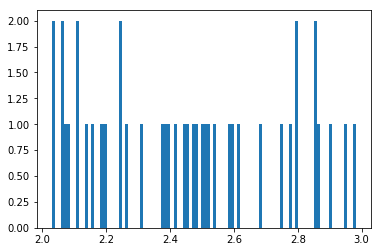

In [145]:
plt.hist(E_real,bins=100)

In [146]:
E_real

array([ 2.06077598,  2.19468736,  2.79996266,  2.74636774,  2.10674919,
        2.98291448,  2.61613058,  2.51960697,  2.43984891,  2.58666543,
        2.85782187,  2.39653259,  2.5016527 ,  2.90356991,  2.86355543,
        2.48460383,  2.38767555,  2.67968121,  2.23931634,  2.59359008,
        2.14154102,  2.03726349,  2.05982387,  2.15413734,  2.10814302,
        2.02948584,  2.8510251 ,  2.44951502,  2.41848871,  2.50719098,
        2.54125805,  2.37712022,  2.07933333,  2.77698962,  2.94605943,
        2.80100146,  2.47481357,  2.25918272,  2.24289255,  2.30627608,
        2.18602855,  2.06770937])